# Intraday Momentum Signals 

This notebook investigates whether there are profitable intraday momentum signals for cryptocurrency data at the 10s interval. 

In [21]:
%load_ext autoreload
%autoreload 2

import datetime as dt
from datetime import timedelta, datetime, date, time
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import time
import plotly.graph_objects as go 
import mplfinance as mpf
from scipy.stats import pearsonr

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Processing/Choice of Coin 

To start with, we will just look at Bitcoin. 

In [2]:
#Binance - BTC data - just use top-level bid/ask data for brevity 
raw_df = pd.read_parquet('data/btc_level1crypto_origin_times_resampled.parquet')

In [7]:
raw_df.isna().sum()

received_time    31267
bid_0_price      31267
ask_0_price      31267
bid_0_size       31267
ask_0_size       31267
symbol           31267
exchange         31267
dtype: int64

In [3]:
df = raw_df[['bid_0_price', 'ask_0_price', 'bid_0_size', 'ask_0_size']].rename(columns={
    'bid_0_price': 'bid', 
    'ask_0_price': 'ask', 
    'bid_0_size': 'bid_size', 
    'ask_0_size': 'ask_size'
})
df['mid'] = (df['bid'] + df['ask'])/2

In [25]:
df.isna().sum()

bid         31267
ask         31267
bid_size    31267
ask_size    31267
mid         31267
dtype: int64

<Axes: xlabel='origin_time'>

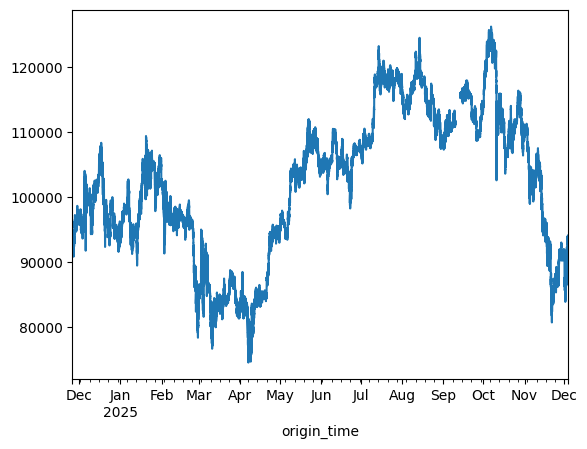

In [26]:
df['mid'].plot()

To avoid the problem of missing data we will simply restrict the training/test data to skip the September gap. 

In [28]:
train_df = df.loc[:'2025-09-01']

In [5]:
train_df.isna().sum()

bid         17
ask         17
bid_size    17
ask_size    17
mid         17
dtype: int64

In [29]:
train_df = df.loc[:'2025-09-01'].ffill()

<Axes: xlabel='origin_time'>

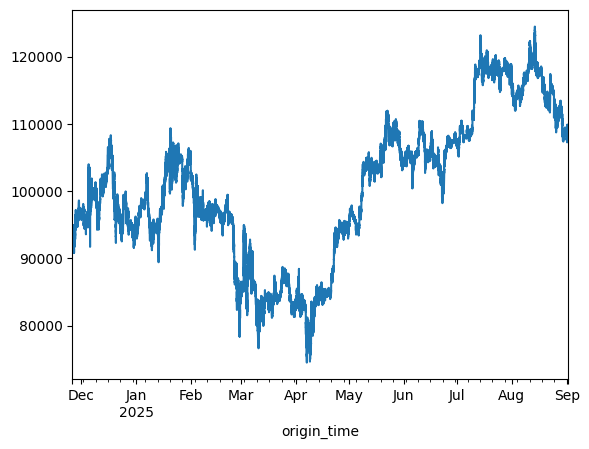

In [35]:
train_df['mid'].plot()

# Signal 1: Time Series Correlation 

Time series momentum means that past returns are positively correlated with future returns. One of the easiest ways to assess this is to calculate the correlation coefficient between lookback and holding period returns for a variety of windows. 

Note that the time tick unit is 10 seconds. 

In [17]:
from test_momentum import test_correlation

In [19]:
correlation_df = test_correlation(train_df['mid'], lookback = np.arange(1, 30), holding = np.arange(1,30)).sort_values(by = ['correlation'], ascending=False)
correlation_df

,lookback,holding,correlation,pvalue,n
0,1,1,0.046057,0.000000e+00,2419198
29,2,1,0.042678,0.000000e+00,1209599
494,18,2,0.040917,6.639204e-51,134399
1,1,2,0.039963,0.000000e+00,1209599
261,10,1,0.037463,7.218611e-76,241919
...,...,...,...,...,...
195,7,22,-0.034637,1.496791e-30,109963
734,26,10,-0.035228,6.006915e-27,93045
78,3,21,-0.037730,1.437540e-37,115199
114,4,28,-0.037745,1.274916e-28,86399


There is a question mark about the validity of the t-test for correlation, but the most important thing to note is that the correlation coefficients between lookback and holding are quite small and not likely to be profitable. 

#TODO - How? 

# Signal 2: Order book imbalances 

Most high-frequency momentum strategies involving extracting order book information. 

The most basic signal is exploiting instantaneous order book imbalances, for example if the bid size is bigger than the ask size, and vice versa. 

In [31]:
train_df['order_book_imbalance'] = (train_df['bid_size'] - train_df['ask_size']) / (train_df['bid_size'] + train_df['ask_size']) #Take as a ratio 

In [46]:
def calc_obi_corr(holding: list[int], df: pd.DataFrame): 
    results = {}
    for horizon in holding:
        #Calculate forward returns 
        fwd_ret = df['mid'].pct_change(horizon).shift(-horizon)
        # subsample every `horizon` steps to avoid overlapping forward return windows
        idx = range(0, len(df), horizon)
        obi = df['order_book_imbalance'].iloc[idx]
        fr = fwd_ret.iloc[idx]

        mask = obi.notna() & fr.notna()
        r, p = pearsonr(obi[mask], fr[mask])
        results[horizon] = {'correlation': r, 'pvalue': p, 'n': mask.sum()}
    
    final = pd.DataFrame(results).T
    final.index.name = 'holding_period'
    return final

In [47]:
HOLDING_PERIOD = [1, 3, 6, 18, 30, 60, 120, 300]
calc_obi_corr(holding = [1, 3, 6, 18, 30, 60, 120, 300], df = train_df)

,correlation,pvalue,n
holding_period,,,
1,0.188273,0.000000e+00,2419199.0
3,0.131122,0.000000e+00,806399.0
6,0.098187,0.000000e+00,403199.0
18,0.056291,9.239172e-95,134399.0
30,0.051026,1.226905e-47,80639.0
60,0.036742,1.585055e-13,40319.0
120,0.026695,1.502160e-04,20159.0
300,0.020070,7.152944e-02,8063.0


Correlation is higher than in purely time series momentum approach.

### Is the size of this correlation enough? 
TODO - See ClaudeAI 

### Is the correlation stable over time? 

/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_15901/890094078.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_df.groupby(pd.Grouper(freq='M'))


<Axes: title={'center': 'OBI vs Forward Return Correlation by Month'}, xlabel='origin_time'>

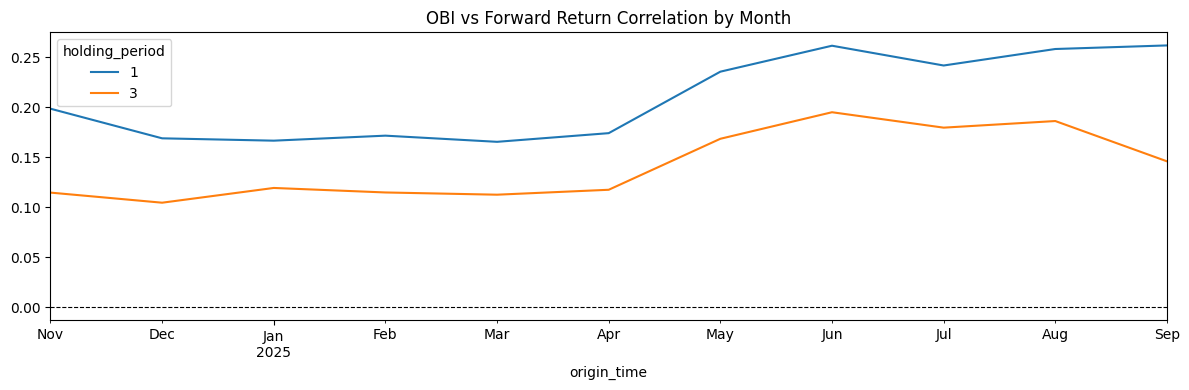

In [73]:
#Visualise by month 
corr_by_month = (
    train_df.groupby(pd.Grouper(freq='M'))
    .apply(lambda x: calc_obi_corr(holding=HOLDING_PERIOD, df=x).iloc[:2])
    .reset_index() 
).pivot(index = 'origin_time', columns = 'holding_period', values = 'correlation')

corr_by_month.plot(
    figsize=(12, 4),
    title='OBI vs Forward Return Correlation by Month'
)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

In [77]:
roll_corr

origin_time
2024-11-26 00:00:00         NaN
2024-11-26 00:00:10         NaN
2024-11-26 00:00:20         NaN
2024-11-26 00:00:30         NaN
2024-11-26 00:00:40         NaN
                         ...   
2025-09-01 23:59:10    0.157139
2025-09-01 23:59:20    0.157782
2025-09-01 23:59:30         NaN
2025-09-01 23:59:40         NaN
2025-09-01 23:59:50         NaN
Length: 2419200, dtype: float64

<Figure size 1400x500 with 0 Axes>

Text(0.5, 1.0, 'Rolling Correlation: OBI vs 3-period Forward Returns')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Correlation')

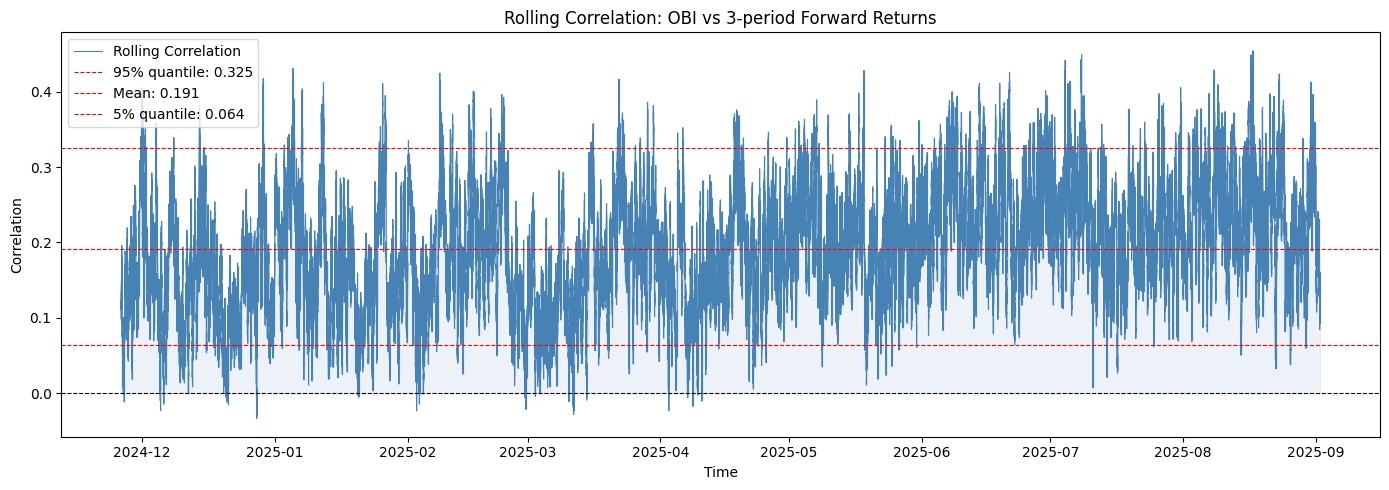

In [80]:
#Visualise/plot via rolling window approach 
roll_corr = train_df['order_book_imbalance'].rolling(1000).corr(train_df['fwd_ret_3'])

plt.figure(figsize=(14, 5))
plt.plot(roll_corr, label='Rolling Correlation', color='steelblue', linewidth=0.8)
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
plt.axhline(y= roll_corr.quantile(0.95), color = 'red', linewidth = 0.8, linestyle = '--', label = f'95% quantile: {roll_corr.quantile(0.95):.3f}')
plt.axhline(y=roll_corr.mean(), color='red', linewidth=0.8, linestyle='--', label=f'Mean: {roll_corr.mean():.3f}')
plt.axhline(y= roll_corr.quantile(0.05), color = 'red', linewidth = 0.8, linestyle = '--', label = f'5% quantile: {roll_corr.quantile(0.05):.3f}')
plt.fill_between(roll_corr.index, roll_corr, 0, alpha=0.1, color='steelblue')
plt.title('Rolling Correlation: OBI vs 3-period Forward Returns')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.legend()
plt.tight_layout()
plt.show()

#TODO 
- Write up data visualisation metrics 

/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_15901/858233975.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby('obi_bin')['fwd_ret_3'].mean().plot(kind='bar')


<Axes: xlabel='obi_bin'>

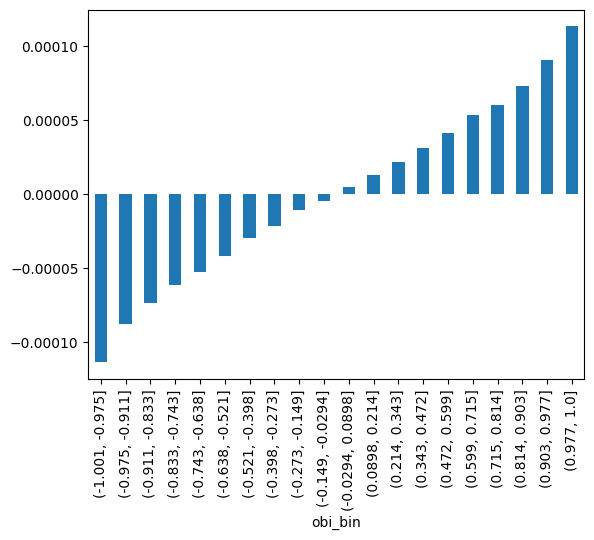

In [74]:
train_df['obi_bin'] = pd.qcut(train_df['order_book_imbalance'], q=20)
train_df.groupby('obi_bin')['fwd_ret_3'].mean().plot(kind='bar')

### Assessing p values - non parametric testing 

This is likely overkill due to the fact that CLT kicks in with large sample size. Furthermore, since we have chosen to avoid overlap between the pairs, the independence assumption behind the t-test is minimally violated. 

In addition, there is significant autocorrelation in the data but we are looking at comparatively short holding period returns - notice the correlation dies off the longer our holding period. So it's unclear what value a block permutation test would have. 

### Profitable/Tradeable?

The momementum is extremely short term, so there is a concern about whether or not fees might realistically wipe out any returns.

As a general first pass, I estimate the net returns less fees of various short term holding periods. At first glance the results appear discouraging, but in fact it's just not informative since it doesn't incorporate our order book imbalance signal. 

In [ ]:
#Calculate net returns after fees (from holding period )

net_returns_df= pd.DataFrame()
for horizon in [1, 3, 6, 18, 30, 60, 120, 300]:
    # Entry cost (pay 0.1% fee)
    entry_cost = train_df['mid'] * (1 + 0.001)
    # Exit proceeds (receive future price minus 0.1% fee)
    exit_proceeds = train_df['mid'].shift(-horizon) * (1 - 0.001)
    # Net return
    net_returns_df[f'net_ret_{horizon}'] = (exit_proceeds - entry_cost) / entry_cost

net_returns_df.mean()

net_ret_1     -0.001998
net_ret_3     -0.001998
net_ret_6     -0.001997
net_ret_18    -0.001996
net_ret_30    -0.001995
net_ret_60    -0.001992
net_ret_120   -0.001986
net_ret_300   -0.001970
dtype: float64

To assess potential profitability, I implement an elementary/crude signal weighted strategy that goes long/short depending on magnitude of the order book imbalance. Note that in calculating the MDD here we are implicitly assuming an initial strategy of no capital constraints. 

In [ ]:
#Signal weighted strategy - crude performance estimates 
TRADES_PER_YEAR  = 365 * 24 * 3600 / 10  
results = {}
for horizon in [1, 3, 6, 18, 30, 60, 120, 300]:
    net_ret = train_df[f'net_ret_{horizon}']
    obi = train_df['order_book_imbalance']
    pnl = obi * net_ret
    cumulative = (1 + pnl).cumprod()    
    results[horizon] = {
        'mean_return': pnl.mean(),
        'raw_sharpe': pnl.mean() / pnl.std(),
        'sharpe': (pnl.mean() / pnl.std() * np.sqrt(TRADES_PER_YEAR)),
        'std': pnl.std(),
        'win_rate': (pnl > 0).mean(),
        'max_drawdown': ((cumulative - cumulative.cummax()) / cumulative.cummax()).min() #how far below all time high? 
    }
pd.DataFrame(results).T

,mean_return,raw_sharpe,sharpe,std,win_rate,max_drawdown
1,0.000066,0.049696,88.251696,0.001326,0.512572,-0.972478
3,0.000073,0.054180,96.215285,0.001351,0.512839,-0.943349
6,0.000075,0.053866,95.657846,0.001388,0.513217,-0.938341
18,0.000075,0.049269,87.494282,0.001523,0.514241,-0.937047
30,0.000075,0.045689,81.136282,0.001646,0.514832,-0.941197
60,0.000073,0.038075,67.615304,0.001908,0.514985,-0.966838
120,0.000072,0.030916,54.901513,0.002342,0.514503,-0.981417
300,0.000070,0.021078,37.431204,0.003314,0.512245,-0.999684


The mean return is miniscule but the trading frequency is very high. 

It is dubious whether this strategy is profitable enough due to the win rate hovering around the 50% mark. Furthermore, the drawdown is massive. 

#TODO - Results analysis 

The Sharpe ratio is massively inflated due to the trading frequency, so we will have to revisit whether this is even a relevant metric - something to do with independence?